# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

from imblearn.over_sampling import SMOTE
from scipy.optimize import minimize

In [2]:
try:
  from deap import base, creator, tools, algorithms
except:
  !pip install deap
  from deap import base, creator, tools, algorithms

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.9 MB/s eta 0:00:00


# Load the dataset

In [3]:
file_path = 'customer_churn.csv'
df = pd.read_csv(file_path)

In [4]:
df.head()

,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Onboard_date,Location,Company,Churn
0,Cameron Williams,42.0,11066.80,0,7.22,8.0,2013-08-30 07:00:40,"10265 Elizabeth Mission Barkerburgh, AK 89518",Harvey LLC,1
1,Kevin Mueller,41.0,11916.22,0,6.50,11.0,2013-08-13 00:38:46,"6157 Frank Gardens Suite 019 Carloshaven, RI 1...",Wilson PLC,1
2,Eric Lozano,38.0,12884.75,0,6.67,12.0,2016-06-29 06:20:07,"1331 Keith Court Alyssahaven, DE 90114","Miller, Johnson and Wallace",1
3,Phillip White,42.0,8010.76,0,6.71,10.0,2014-04-22 12:43:12,"13120 Daniel Mount Angelabury, WY 30645-4695",Smith Inc,1
4,Cynthia Norton,37.0,9191.58,0,5.56,9.0,2016-01-19 15:31:15,"765 Tricia Row Karenshire, MH 71730",Love-Jones,1


# Basic Data Analysis

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Names            900 non-null    object 
 1   Age              900 non-null    float64
 2   Total_Purchase   900 non-null    float64
 3   Account_Manager  900 non-null    int64  
 4   Years            900 non-null    float64
 5   Num_Sites        900 non-null    float64
 6   Onboard_date     900 non-null    object 
 7   Location         900 non-null    object 
 8   Company          900 non-null    object 
 9   Churn            900 non-null    int64  
dtypes: float64(4), int64(2), object(4)
memory usage: 70.4+ KB


In [6]:
df.describe()

,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Churn
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
mean,41.816667,10062.824033,0.481111,5.273156,8.587778,0.166667
std,6.127560,2408.644532,0.499921,1.274449,1.764836,0.372885
min,22.000000,100.000000,0.000000,1.000000,3.000000,0.000000
25%,38.000000,8497.122500,0.000000,4.450000,7.000000,0.000000
50%,42.000000,10045.870000,0.000000,5.215000,8.000000,0.000000
75%,46.000000,11760.105000,1.000000,6.110000,10.000000,0.000000
max,65.000000,18026.010000,1.000000,9.150000,14.000000,1.000000


In [7]:
df['Churn'].value_counts()

Churn
0    750
1    150
Name: count, dtype: int64

In [8]:
print('Minority Class', round(15000/900,2),'%')
print('Majority Class', round(75000/900,2),'%')

Minority Class 16.67 %
Majority Class 83.33 %


In [17]:
# Only include numeric data
df_numeric = df.select_dtypes(include=[np.number])

# Extract features and target variable
X_feature_pre = df_numeric.drop(columns=['Churn']).values
y_feature_pre = df['Churn'].values

In [16]:
# Fischer Score Function
def fischer_score(X_feature_pre, y_feature_pre):
    unique_classes = np.unique(y_feature_pre) # [0 and 1]
    fischer_scores = []

    for i in range(X_feature_pre.shape[1]): # X.shape[1] = 5 (5 columns)
        feature = X_feature_pre[:, i] # Get all individual values for each 5 columns for all 900 rows
        numerator = 0
        denominator = 0
        overall_mean = np.mean(feature) # Get the mean of all 5 columns

        for cls in unique_classes:
            cls_feature = feature[y_feature_pre == cls] # Get the feature for each classes separately
            cls_mean = np.mean(cls_feature) # mean of each classes for each features
            cls_std = np.std(cls_feature) # standard deviation of each classes for each features
            cls_size = cls_feature.shape[0] # number of samples for each classes

            numerator += cls_size * (cls_mean - overall_mean) ** 2
            denominator += cls_size * cls_std ** 2

        fischer_score = numerator / denominator
        fischer_scores.append(fischer_score)

    return np.mean(fischer_scores)


In [20]:
# Imbalance Ratio Function
def imbalance_ratio(y_feature_pre):
    unique_classes, counts = np.unique(y_feature_pre, return_counts=True)
    majority_class = max(counts)
    minority_class = min(counts)
    return minority_class / majority_class

In [21]:
# Calculate Fischer Score
fischer_score_value = fischer_score(X_feature_pre, y_feature_pre)

# Calculate Imbalance Ratio
imbalance_ratio_value = imbalance_ratio(y_feature_pre)

# Calculate Volume (number of samples)
volume = X_feature_pre.shape[0]

# Calculate Number of Features
num_features = X_feature_pre.shape[1]

# Create DataFrame for the results
results_df = pd.DataFrame({
    "Metric": ["Imbalance Ratio", "Fischer Score", "Volume", "Number of Features"],
    "Value": [imbalance_ratio_value, fischer_score_value, volume, num_features]
})

results_df

,Metric,Value
0,Imbalance Ratio,0.200000
1,Fischer Score,0.088495
2,Volume,900.000000
3,Number of Features,5.000000


# Handling Unbalanced Dataset

In [22]:
# Analyze class distribution
class_distribution = df['Churn'].value_counts(normalize=True)
class_distribution

Churn
0    0.833333
1    0.166667
Name: proportion, dtype: float64

In [23]:
df = df[['Age', 'Total_Purchase', 'Account_Manager', 'Years', 'Num_Sites', 'Churn']]
X = df.drop(columns=['Churn'])
y = df['Churn']

# Apply SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Combine X_res and y_res into a DataFrame
balanced_df_smote = pd.concat([pd.DataFrame(X_res, columns=X.columns), pd.DataFrame(y_res, columns=['Churn'])], axis=1)

# Check the distribution after SMOTE
balanced_class_distribution_smote = balanced_df_smote['Churn'].value_counts(normalize=True)
balanced_class_distribution_smote

Churn
1    0.5
0    0.5
Name: proportion, dtype: float64

# Analysis of balanced dataset

In [24]:
# balanced_df.head()
balanced_df_smote.head()

,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Churn
0,42.0,11066.80,0,7.22,8.0,1
1,41.0,11916.22,0,6.50,11.0,1
2,38.0,12884.75,0,6.67,12.0,1
3,42.0,8010.76,0,6.71,10.0,1
4,37.0,9191.58,0,5.56,9.0,1


In [25]:
# balanced_df['Churn'].value_counts()
balanced_df_smote['Churn'].value_counts()

Churn
1    750
0    750
Name: count, dtype: int64

In [26]:
balanced_df_smote.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              1500 non-null   float64
 1   Total_Purchase   1500 non-null   float64
 2   Account_Manager  1500 non-null   int64  
 3   Years            1500 non-null   float64
 4   Num_Sites        1500 non-null   float64
 5   Churn            1500 non-null   int64  
dtypes: float64(4), int64(2)
memory usage: 70.4 KB


In [28]:
X_feature_post = balanced_df_smote.drop(columns=['Churn']).values
y_feature_post = balanced_df_smote['Churn'].values

# Calculate Fischer Score
fischer_score_value_balanced = fischer_score(X_feature_post, y_feature_post)

# Calculate Imbalance Ratio
imbalance_ratio_value_balanced = imbalance_ratio(y_feature_post)

# Calculate Volume (number of samples)
volume_balanced = X_feature_post.shape[0]

# Calculate Number of Features
num_features_balanced = X_feature_post.shape[1]

# Create DataFrame for the results
results_df = pd.DataFrame({
    "Metric": ["Imbalance Ratio", "Fischer Score", "Volume", "Number of Features"],
    "Value": [imbalance_ratio_value_balanced, fischer_score_value_balanced, volume_balanced, num_features_balanced]
})

results_df

,Metric,Value
0,Imbalance Ratio,1.000000
1,Fischer Score,0.173983
2,Volume,1500.000000
3,Number of Features,5.000000


# Model Training

## Using Scikit Learn Model - Logistic Regression

### Data Preparation

In [29]:
X_balanced = balanced_df_smote.drop(columns=['Churn'])
y_balanced = balanced_df_smote['Churn']
X_balanced.shape, y_balanced.shape

((1500, 5), (1500,))

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

### Data Standardization

In [31]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Model Preparation and Training

In [32]:
lr = LogisticRegression(random_state=42)

In [33]:
lr.fit(X_train_scaled, y_train)

LogisticRegression(random_state=42)

### Prediction

In [35]:
y_pred = lr.predict(X_test_scaled)

In [42]:
y_pred_prob = lr.predict_proba(X_test_scaled)[:,1]

# this will give 2d array: prediction probability of class0 and class1. Desired outcome is 1 so 2nd column is selected.
# everything (start to end) of column 1 → [:, 1]

### Model Evaluation

In [44]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("accuracy =", accuracy)
print("precision =", precision)
print("recall =", recall)
print("f1 =", f1)
print("roc_auc =", roc_auc)
print("conf_matrix\n", conf_matrix)
print("\nclass_report\n", class_report)

accuracy = 0.8422222222222222
precision = 0.880184331797235
recall = 0.809322033898305
f1 = 0.8432671081677704
roc_auc = 0.9230952003801679
conf_matrix
 [[188  26]
 [ 45 191]]

class_report
               precision    recall  f1-score   support

           0       0.81      0.88      0.84       214
           1       0.88      0.81      0.84       236

    accuracy                           0.84       450
   macro avg       0.84      0.84      0.84       450
weighted avg       0.85      0.84      0.84       450



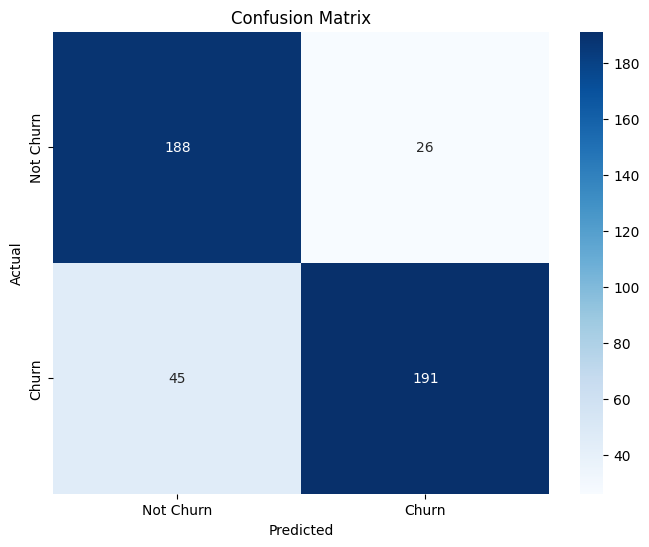

In [45]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Using ANN

### Defining Model

In [46]:
# Define the neural network model
model = Sequential([
    Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                384       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3009 (11.75 KB)
Trainable params: 3009 (11.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Train the model

In [48]:
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
27/27 [==============================] - 2s 15ms/step - loss: 0.6726 - accuracy: 0.6238 - val_loss: 0.6387 - val_accuracy: 0.7429
Epoch 2/50
27/27 [==============================] - 0s 6ms/step - loss: 0.5711 - accuracy: 0.7988 - val_loss: 0.5145 - val_accuracy: 0.8238
Epoch 3/50
27/27 [==============================] - 0s 4ms/step - loss: 0.4488 - accuracy: 0.8262 - val_loss: 0.4046 - val_accuracy: 0.8286
Epoch 4/50
27/27 [==============================] - 0s 5ms/step - loss: 0.3847 - accuracy: 0.8381 - val_loss: 0.3733 - val_accuracy: 0.8238
Epoch 5/50
27/27 [==============================] - 0s 4ms/step - loss: 0.3735 - accuracy: 0.8417 - val_loss: 0.3671 - val_accuracy: 0.8429
Epoch 6/50
27/27 [==============================] - 0s 4ms/step - loss: 0.3652 - accuracy: 0.8500 - val_loss: 0.3645 - val_accuracy: 0.8286
Epoch 7/50
27/27 [==============================] - 0s 4ms/step - loss: 0.3611 - accuracy: 0.8429 - val_loss: 0.3696 - val_accuracy: 0.8286
Epoch 8/50
27/27 [=

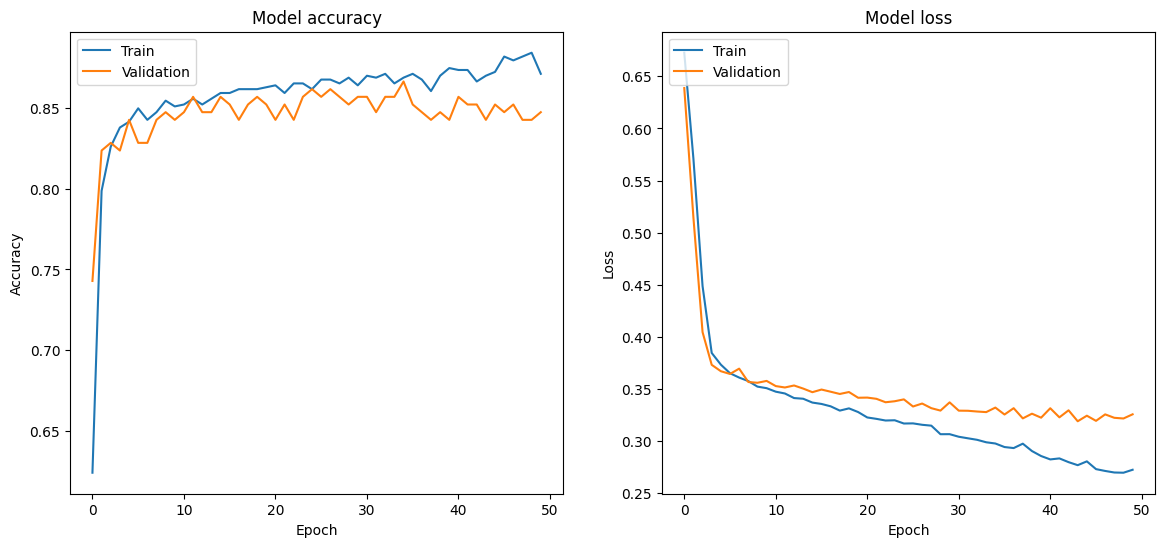

In [49]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

### Making predictions

In [50]:
y_pred_prob = model.predict(X_test_scaled).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

15/15 [==============================] - 0s 3ms/step


### Evaluating the model

In [51]:
accuracy_nn = accuracy_score(y_test, y_pred)
precision_nn = precision_score(y_test, y_pred)
recall_nn = recall_score(y_test, y_pred)
f1_nn = f1_score(y_test, y_pred)
roc_auc_nn = roc_auc_score(y_test, y_pred_prob)
conf_matrix_nn = confusion_matrix(y_test, y_pred)
class_report_nn = classification_report(y_test, y_pred)

metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC'],
    'Score': [accuracy_nn, precision_nn, recall_nn, f1_nn, roc_auc_nn]
})

# Display the evaluation results
print(metrics_df)
print("\nConfusion Matrix:\n", conf_matrix_nn)
print("\nClassification Report:\n", class_report_nn)

      Metric     Score
0   Accuracy  0.884444
1  Precision  0.903509
2     Recall  0.872881
3   F1 Score  0.887931
4    ROC-AUC  0.945965

Confusion Matrix:
 [[192  22]
 [ 30 206]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.90      0.88       214
           1       0.90      0.87      0.89       236

    accuracy                           0.88       450
   macro avg       0.88      0.89      0.88       450
weighted avg       0.89      0.88      0.88       450



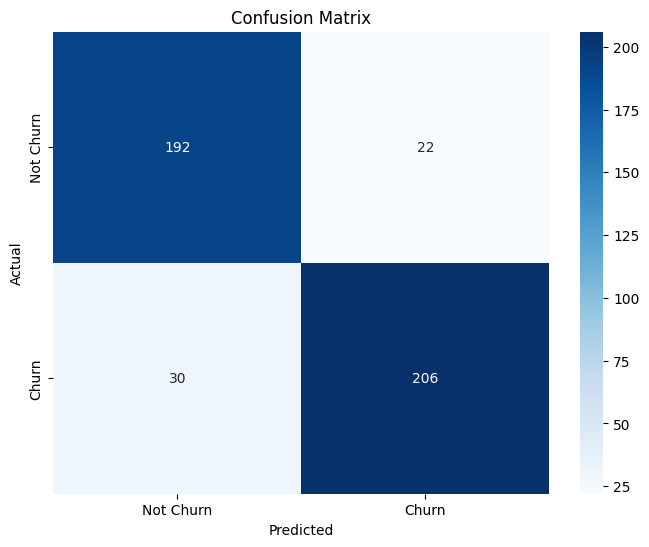

In [52]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_nn, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Performance Evaluation for Logistic Regression Model and ANN Model

In [53]:
# Data for logistic regression and ANN evaluations
eval_result = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "ROC-AUC"],
    "Logistic Regression Score": [accuracy, precision, accuracy_nn, accuracy_nn, accuracy_nn],
    "ANN Score": [accuracy_nn, precision_nn, recall_nn, f1_nn, roc_auc_nn]
}

df = pd.DataFrame(eval_result)
print("Model Evaluation Results:")
df

Model Evaluation Results:


,Metric,Logistic Regression Score,ANN Score
0,Accuracy,0.842222,0.884444
1,Precision,0.880184,0.903509
2,Recall,0.884444,0.872881
3,F1 Score,0.884444,0.887931
4,ROC-AUC,0.884444,0.945965


# Implementing Counterfactual Learning Methods

## Wachter’s method

In [54]:
# Wachter's Function
def wachter_function(x, model, original_instance, desired_prediction, lambda_param=0.01):
    x = x.reshape(1, -1) # 1 row * n column (Model requirement is 2D array)
    pred_prob = model.predict(x)[0, 0]
    prediction_loss = (pred_prob - desired_prediction) ** 2
    proximity_loss = np.sum((x - original_instance) ** 2)
    return lambda_param * prediction_loss + proximity_loss

In [55]:
# Select an instance from the test set
instance_idx = 0
wachter_original_instance = X_test_scaled[instance_idx]
desired_prediction = 1  # 1 (churn)

# Generate the counterfactual explanation
# Main function (to be passed directly) → wachter_function
# Other parameters that is to be passed to wachter_function must be passed using args
result = minimize(wachter_function, wachter_original_instance, args=(model, wachter_original_instance, desired_prediction), method='L-BFGS-B')
print(result)

wachter_counterfactual_instance = result.x
# Show the original and counterfactual instances
print("\nOriginal Instance:", wachter_original_instance)
print("\nCounterfactual Instance:", wachter_counterfactual_instance)

# Predict the probability for the counterfactual instance
wachter_counterfactual_pred_prob = model.predict(wachter_counterfactual_instance.reshape(1, -1))[0, 0]
print("\nCounterfactual Prediction Probability:", wachter_counterfactual_pred_prob)

1/1 [==============================] - 0s 28ms/step
  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: 7.087616728540524e-05
        x: [ 8.975e-01 -8.042e-01 -9.002e-01  8.743e-01  8.618e-01]
      nit: 0
      jac: [ 1.000e-08  1.004e-02  1.000e-08  1.000e-08  1.000e-08]
     nfev: 126
     njev: 21
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>

Original Instance: [ 0.8974801  -0.80419889 -0.90019155  0.87428497  0.8618289 ]

Counterfactual Instance: [ 0.8974801  -0.80419889 -0.90019155  0.87428497  0.8618289 ]
1/1 [==============================] - 0s 20ms/step

Counterfactual Prediction Probability: 0.915812


## Growing Spheres counterfactual generation method

In [56]:
# Growing Spheres Function
def growing_spheres_function(model, original_instance, desired_prediction, step_size=0.1, max_iterations=5000):
    original_instance = original_instance.reshape(1, -1)
    for i in range(max_iterations):
        # Generate a random perturbation (gaussian noise) of mean = 0 and std_dev = step_size
        perturbation = np.random.normal(0, step_size, original_instance.shape)
        counterfactual_instance = original_instance + perturbation
        pred_prob = model.predict(counterfactual_instance)[0, 0]
        if (desired_prediction == 1 and pred_prob > 0.5) or (desired_prediction == 0 and pred_prob <= 0.5):
            return counterfactual_instance.flatten(), pred_prob
    return None, None

In [57]:
# Select an instance from the test set
instance_idx = 0
growing_spheres_original_instance = X_test_scaled[instance_idx]
desired_prediction = 1  # churn

# Generate the counterfactual explanation using Growing Spheres
growing_spheres_counterfactual_instance, growing_spheres_counterfactual_pred_prob = growing_spheres_function(model, growing_spheres_original_instance, desired_prediction)

# Show the original and counterfactual instances
print("\nOriginal Instance:", growing_spheres_original_instance)
print("\nCounterfactual Instance:", growing_spheres_counterfactual_instance)

# Predict the probability for the counterfactual instance
if growing_spheres_counterfactual_instance is not None:
    print("\nCounterfactual Prediction Probability:", growing_spheres_counterfactual_pred_prob)
else:
    print("\nNo valid counterfactual instance found.")

1/1 [==============================] - 0s 23ms/step

Original Instance: [ 0.8974801  -0.80419889 -0.90019155  0.87428497  0.8618289 ]

Counterfactual Instance: [ 0.9056508  -0.78189815 -0.76449618  0.73277917  0.87019316]

Counterfactual Prediction Probability: 0.91076404


## Genetic Algorithm

In [58]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", np.ndarray, fitness=creator.FitnessMin)

original_instance = X_test_scaled[instance_idx]

def evaluate(individual, model, original_instance, desired_prediction):
    individual = np.array(individual).reshape(1, -1)
    prediction = model.predict(individual)[0, 0]
    prediction_loss = (prediction - desired_prediction) ** 2
    proximity_loss = np.sum((individual - original_instance) ** 2)
    return prediction_loss + proximity_loss,

toolbox = base.Toolbox()
toolbox.register("attr_float", np.random.uniform, -1, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=X_test_scaled.shape[1])
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate, model=model, original_instance=original_instance, desired_prediction=desired_prediction)

def is_similar(ind1, ind2):
    return np.allclose(ind1, ind2, atol=1e-5)

In [59]:
# Genetic Algoritm Function
def genetic_algorithm_counterfactual(model, original_instance, desired_prediction, n_generations=100, population_size=50):
    toolbox.register("evaluate", evaluate, model=model, original_instance=original_instance, desired_prediction=desired_prediction)
    population = toolbox.population(n=population_size)

    hof = tools.HallOfFame(1, similar=is_similar)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)

    population, log = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=n_generations, stats=stats, halloffame=hof, verbose=True)

    best_individual = hof[0]
    return best_individual, model.predict(np.array(best_individual).reshape(1, -1))[0, 0], log

In [60]:
# Select an instance from the test set
instance_idx = 0
original_instance = X_test_scaled[instance_idx]
desired_prediction = 1  # (churn)

# Generate the counterfactual explanation using Genetic Algorithm
counterfactual_instance, counterfactual_pred_prob, log = genetic_algorithm_counterfactual(model, original_instance, desired_prediction)

# Show the original and counterfactual instances
print("\nOriginal Instance:", original_instance)
print("\nCounterfactual Instance:", counterfactual_instance)

# Predict the probability for the counterfactual instance
if counterfactual_instance is not None:
    print("\nCounterfactual Prediction Probability:", counterfactual_pred_prob)
else:
    print("\nNo valid counterfactual instance found.")


1/1 [==============================] - 0s 21ms/step
gen	nevals	avg    	min     	max   
0  	50    	5.40228	0.376558	10.716
1/1 [==============================] - 0s 22ms/step
1  	33    	2.81574	0.376558	7.31764
1/1 [==============================] - 0s 22ms/step
2  	26    	1.42852	0.191984	3.91622
1/1 [==============================] - 0s 30ms/step
3  	27    	0.689765	0.174738	2.67448
1/1 [==============================] - 0s 21ms/step
4  	39    	0.341463	0.132311	1.55541
1/1 [==============================] - 0s 20ms/step
5  	30    	0.243503	0.130723	0.459398
1/1 [==============================] - 0s 22ms/step
6  	28    	0.189076	0.117622	0.309676
1/1 [==============================] - 0s 20ms/step
7  	31    	0.148792	0.0851275	0.324531
1/1 [==============================] - 0s 30ms/step
8  	26    	0.124036	0.0587202	0.184872
1/1 [==============================] - 0s 22ms/step
9  	26    	0.116307	0.0522884	0.281262
1/1 [==============================] - 0s 25ms/step
10 	31    	0.085154

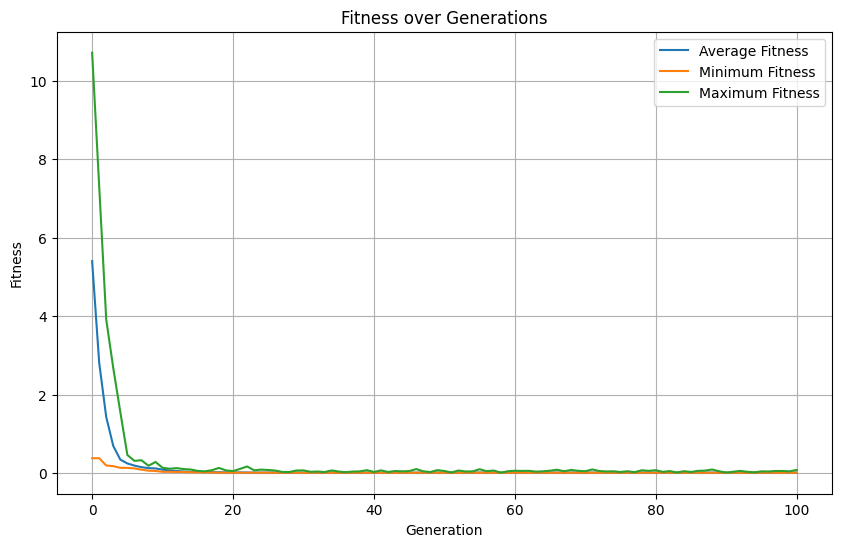

In [61]:
# Plot the fitness values over generations
gen = log.select("gen")
avg = log.select("avg")
min_ = log.select("min")
max_ = log.select("max")

plt.figure(figsize=(10, 6))
plt.plot(gen, avg, label='Average Fitness')
plt.plot(gen, min_, label='Minimum Fitness')
plt.plot(gen, max_, label='Maximum Fitness')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Fitness over Generations')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Comparing Result

In [62]:
result = {
    "Method": ["Original Instance", "Watcher's Method", "Growing Spheres Method", "Genetic Algorithm"],
    "Original Instance": [
        "[-0.69897287, 0.64174408, 0.96628239, 0.49253796, -0.23253799]",
        "[-0.69897287, 0.64174408, 0.96628239, 0.49253796, -0.23253799]",
        "[-0.69897287, 0.64174408, 0.96628239, 0.49253796, -0.23253799]",
        "[-0.69897287, 0.64174408, 0.96628239, 0.49253796, -0.23253799]"
    ],
    "Counterfactual Instance": [
        "N/A",
        "[ 0.8974801  -0.80419889 -0.90019155  0.87428497  0.8618289 ]",
        "[ 0.67647869 -0.94205153 -0.9418846   0.9788736   0.80669465]",
        "[ 0.89978881 -0.80321893 -0.89906947  0.87416978  0.87192014]"
    ],
    "Prediction Probability": [
        "N/A",
        0.9244888,
        0.9046804,
        0.92598253
    ]
}

df = pd.DataFrame(result)
df

,Method,Original Instance,Counterfactual Instance,Prediction Probability
0,Original Instance,"[-0.69897287, 0.64174408, 0.96628239, 0.492537...",N/A,N/A
1,Watcher's Method,"[-0.69897287, 0.64174408, 0.96628239, 0.492537...",[ 0.8974801 -0.80419889 -0.90019155 0.874284...,0.924489
2,Growing Spheres Method,"[-0.69897287, 0.64174408, 0.96628239, 0.492537...",[ 0.67647869 -0.94205153 -0.9418846 0.978873...,0.90468
3,Genetic Algorithm,"[-0.69897287, 0.64174408, 0.96628239, 0.492537...",[ 0.89978881 -0.80321893 -0.89906947 0.874169...,0.925983


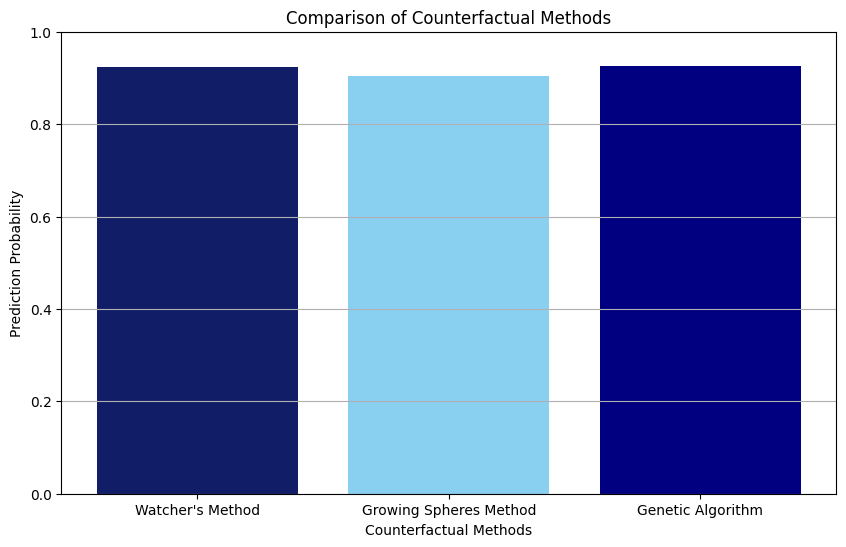

In [63]:
# Plot the comparison of prediction probabilities
methods = df["Method"][1:]  # Exclude the "Original Instance"
probabilities = df["Prediction Probability"][1:]  # Exclude the "Original Instance"
probabilities = [float(prob) for prob in probabilities]

plt.figure(figsize=(10, 6))
plt.bar(methods, probabilities, color=['#111e67', '#89cff0', '#000080'])
plt.xlabel("Counterfactual Methods")
plt.ylabel("Prediction Probability")
plt.title("Comparison of Counterfactual Methods")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()
